# UML Class Diagram Dataset Exploration

This notebook downloads and explores the Kaggle UML Class Diagram Dataset.

**Dataset**: [UML Class Diagram Dataset | Bounded Box + Rating](https://www.kaggle.com/datasets/domenicoarm/uml-class-diagram-dataset-bounded-box-rating)

**Dataset Structure**:
- `UML_YOLOv8/` - YOLO format with train/valid/test splits
- `Faster_R-CNN/` - XML annotations (PASCAL VOC format)
- `rating_images.csv` - Quality ratings for images

**Contents**:
1. Download dataset using kagglehub
2. Explore file structure
3. Load YOLO annotations from proper directory structure
4. Visualize sample images with bounding boxes
5. Load and analyze quality ratings
6. Annotation statistics

In [1]:
import os
import sys
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path
from collections import Counter
import yaml

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## 1. Download Dataset

Using `kagglehub` to download the dataset. It will be cached locally after the first download.

In [2]:
# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download(
    "domenicoarm/uml-class-diagram-dataset-bounded-box-rating"
)

dataset_dir = Path(dataset_path)
print(f"Dataset downloaded to: {dataset_path}")

100%|██████████| 128M/128M [00:03<00:00, 36.9MB/s] 

Extracting files...


Dataset downloaded to: C:\Users\Aiden Smith\.cache\kagglehub\datasets\domenicoarm\uml-class-diagram-dataset-bounded-box-rating\versions\2


## 2. Explore File Structure

In [3]:
# Count file types
file_types = Counter()
all_files = list(dataset_dir.rglob("*"))

for f in all_files:
    if f.is_file():
        file_types[f.suffix.lower()] += 1

print("File type distribution:")
for ext, count in sorted(file_types.items(), key=lambda x: -x[1]):
    print(f"  {ext if ext else '(no extension)'}: {count}")

File type distribution:
  .xml: 641
  .jpeg: 639
  .txt: 623
  .jpg: 621
  .bmp: 2
  .csv: 1
  .yaml: 1


In [4]:
# Display directory structure
def show_tree(path, prefix="", max_depth=3, current_depth=0, max_files=5):
    """Display directory tree structure."""
    if current_depth >= max_depth:
        return
    
    path = Path(path)
    contents = sorted(path.iterdir())
    
    dirs = [c for c in contents if c.is_dir()]
    files = [c for c in contents if c.is_file()]
    
    for f in files[:max_files]:
        print(f"{prefix}├── {f.name}")
    if len(files) > max_files:
        print(f"{prefix}├── ... ({len(files) - max_files} more files)")
    
    for d in dirs:
        print(f"{prefix}├── {d.name}/")
        show_tree(d, prefix + "│   ", max_depth, current_depth + 1, max_files)

print(f"Dataset structure:")
show_tree(dataset_path)

Dataset structure:
├── rating_images.csv
├── Faster_R-CNN/
│   ├── Faster_R-CNN/
│   │   ├── 1.jpeg
│   │   ├── 1.xml
│   │   ├── 10.jpeg
│   │   ├── 10.xml
│   │   ├── 100.jpeg
│   │   ├── ... (1277 more files)
├── UML_YOLOv8/
│   ├── data.yaml
│   ├── README.dataset.txt
│   ├── README.roboflow.txt
│   ├── test/
│   │   ├── images/
│   │   ├── labels/
│   ├── train/
│   │   ├── images/
│   │   ├── labels/
│   ├── valid/
│   │   ├── images/
│   │   ├── labels/


## 3. Load Class Configuration from data.yaml

The YOLO dataset includes a `data.yaml` file with the correct class mappings.

In [5]:
# Load class names from data.yaml
data_yaml_path = dataset_dir / "UML_YOLOv8" / "data.yaml"

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("YOLO Dataset Configuration:")
print(f"  Number of classes: {data_config['nc']}")
print(f"  Class names: {data_config['names']}")

# Create class mapping from data.yaml
CLASS_NAMES = {i: name for i, name in enumerate(data_config['names'])}
CLASS_COLORS = {
    0: "green",    # arrow
    1: "blue",     # class
    2: "red"       # cross
}

print("\nClass ID mapping:")
for class_id, name in CLASS_NAMES.items():
    print(f"  {class_id}: {name} ({CLASS_COLORS[class_id]})")

YOLO Dataset Configuration:
  Number of classes: 3
  Class names: ['arrow', 'class', 'cross']

Class ID mapping:
  0: arrow (green)
  1: class (blue)
  2: cross (red)


## 4. YOLO Dataset Helper Functions

The YOLO dataset has a specific structure:
- Images in `{split}/images/`
- Labels in `{split}/labels/` (same filename, .txt extension)

In [6]:
def get_yolo_label_path(image_path):
    """
    Get the label path for a YOLO format image.
    YOLO stores images in images/ and labels in labels/ subdirectories.
    """
    # image_path: .../split/images/filename.jpg
    # label_path: .../split/labels/filename.txt
    return image_path.parent.parent / "labels" / image_path.with_suffix('.txt').name


def load_yolo_split(dataset_path, split='train'):
    """
    Load all image-label pairs from a YOLO dataset split.
    
    Args:
        dataset_path: Path to dataset root
        split: 'train', 'valid', or 'test'
    
    Returns:
        List of dicts with 'image' and 'label' paths
    """
    images_dir = Path(dataset_path) / "UML_YOLOv8" / split / "images"
    
    if not images_dir.exists():
        print(f"Warning: {images_dir} does not exist")
        return []
    
    pairs = []
    for img_path in images_dir.glob("*"):
        if img_path.suffix.lower() in {'.jpg', '.jpeg', '.png'}:
            label_path = get_yolo_label_path(img_path)
            if label_path.exists():
                pairs.append({
                    'image': img_path,
                    'label': label_path
                })
    
    return pairs


def parse_yolo_annotation(txt_path, img_width, img_height):
    """
    Parse YOLO format annotation file.
    
    YOLO format: class_id x_center y_center width height (all normalized 0-1)
    
    Returns list of dicts with absolute pixel coordinates.
    """
    annotations = []
    
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height
                
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                
                annotations.append({
                    'class_id': class_id,
                    'class_name': CLASS_NAMES.get(class_id, f"Unknown_{class_id}"),
                    'x1': x1,
                    'y1': y1,
                    'x2': x1 + width,
                    'y2': y1 + height,
                    'width': width,
                    'height': height
                })
    
    return annotations

## 5. Load YOLO Dataset Splits

In [7]:
# Load all splits
train_data = load_yolo_split(dataset_dir, 'train')
valid_data = load_yolo_split(dataset_dir, 'valid')
test_data = load_yolo_split(dataset_dir, 'test')

print(f"YOLO Dataset splits:")
print(f"  Train: {len(train_data)} image-label pairs")
print(f"  Valid: {len(valid_data)} image-label pairs")
print(f"  Test:  {len(test_data)} image-label pairs")
print(f"  Total: {len(train_data) + len(valid_data) + len(test_data)} pairs")

YOLO Dataset splits:
  Train: 497 image-label pairs
  Valid: 61 image-label pairs
  Test:  63 image-label pairs
  Total: 621 pairs


## 6. Visualization Function

In [8]:
def visualize_image_with_boxes(image_path, annotations, title=None, ax=None):
    """
    Display image with bounding boxes overlaid.
    """
    img = Image.open(image_path)
    img_array = np.array(img)
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(14, 10))
    
    ax.imshow(img_array)
    
    for ann in annotations:
        x1, y1 = ann['x1'], ann['y1']
        width = ann.get('width', ann['x2'] - ann['x1'])
        height = ann.get('height', ann['y2'] - ann['y1'])
        
        class_id = ann.get('class_id', 0)
        color = CLASS_COLORS.get(class_id, 'yellow')
        
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor=color,
            facecolor='none',
            linestyle='-'
        )
        ax.add_patch(rect)
        
        label = ann.get('class_name', f"Class {class_id}")
        ax.text(
            x1, y1 - 5,
            label,
            color='white',
            fontsize=8,
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.7)
        )
    
    ax.set_title(title or Path(image_path).name)
    ax.axis('off')
    
    return ax

## 7. Display Sample Images with Bounding Boxes

In [9]:
# Display first sample from training set
if train_data:
    sample = train_data[0]
    print(f"Sample image: {sample['image'].name}")
    print(f"Label file: {sample['label'].name}")
    
    img = Image.open(sample['image'])
    print(f"Image size: {img.size}")
    
    annotations = parse_yolo_annotation(
        sample['label'], 
        img.size[0], 
        img.size[1]
    )
    print(f"Annotations: {len(annotations)} objects")
    
    # Show annotation details
    for ann in annotations[:5]:
        print(f"  - {ann['class_name']}: ({ann['x1']:.0f}, {ann['y1']:.0f}) to ({ann['x2']:.0f}, {ann['y2']:.0f})")
    if len(annotations) > 5:
        print(f"  ... and {len(annotations) - 5} more")

Sample image: 101_jpeg.rf.33923d298ec2d468e5ab091a9db90108.jpg
Label file: 101_jpeg.rf.33923d298ec2d468e5ab091a9db90108.txt
Image size: (1124, 610)
Annotations: 30 objects
  - class: (304, 216) to (426, 332)
  - class: (297, 13) to (407, 126)
  - class: (59, 45) to (187, 156)
  - class: (43, 191) to (165, 298)
  - class: (46, 340) to (165, 443)
  ... and 25 more


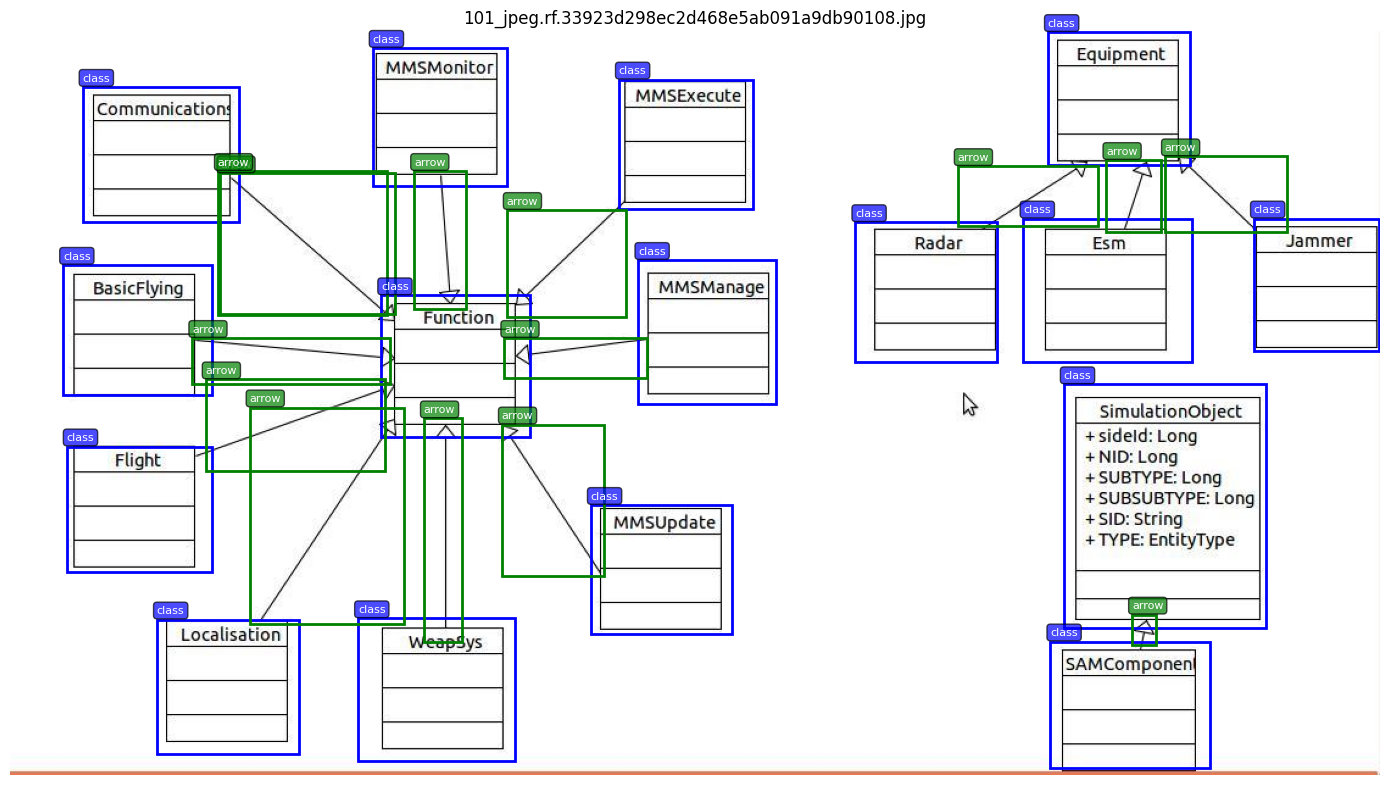

In [10]:
# Visualize first sample with bounding boxes
if train_data:
    sample = train_data[0]
    img = Image.open(sample['image'])
    annotations = parse_yolo_annotation(sample['label'], img.size[0], img.size[1])
    
    fig, ax = plt.subplots(1, figsize=(14, 10))
    visualize_image_with_boxes(sample['image'], annotations, ax=ax)
    plt.tight_layout()
    plt.show()

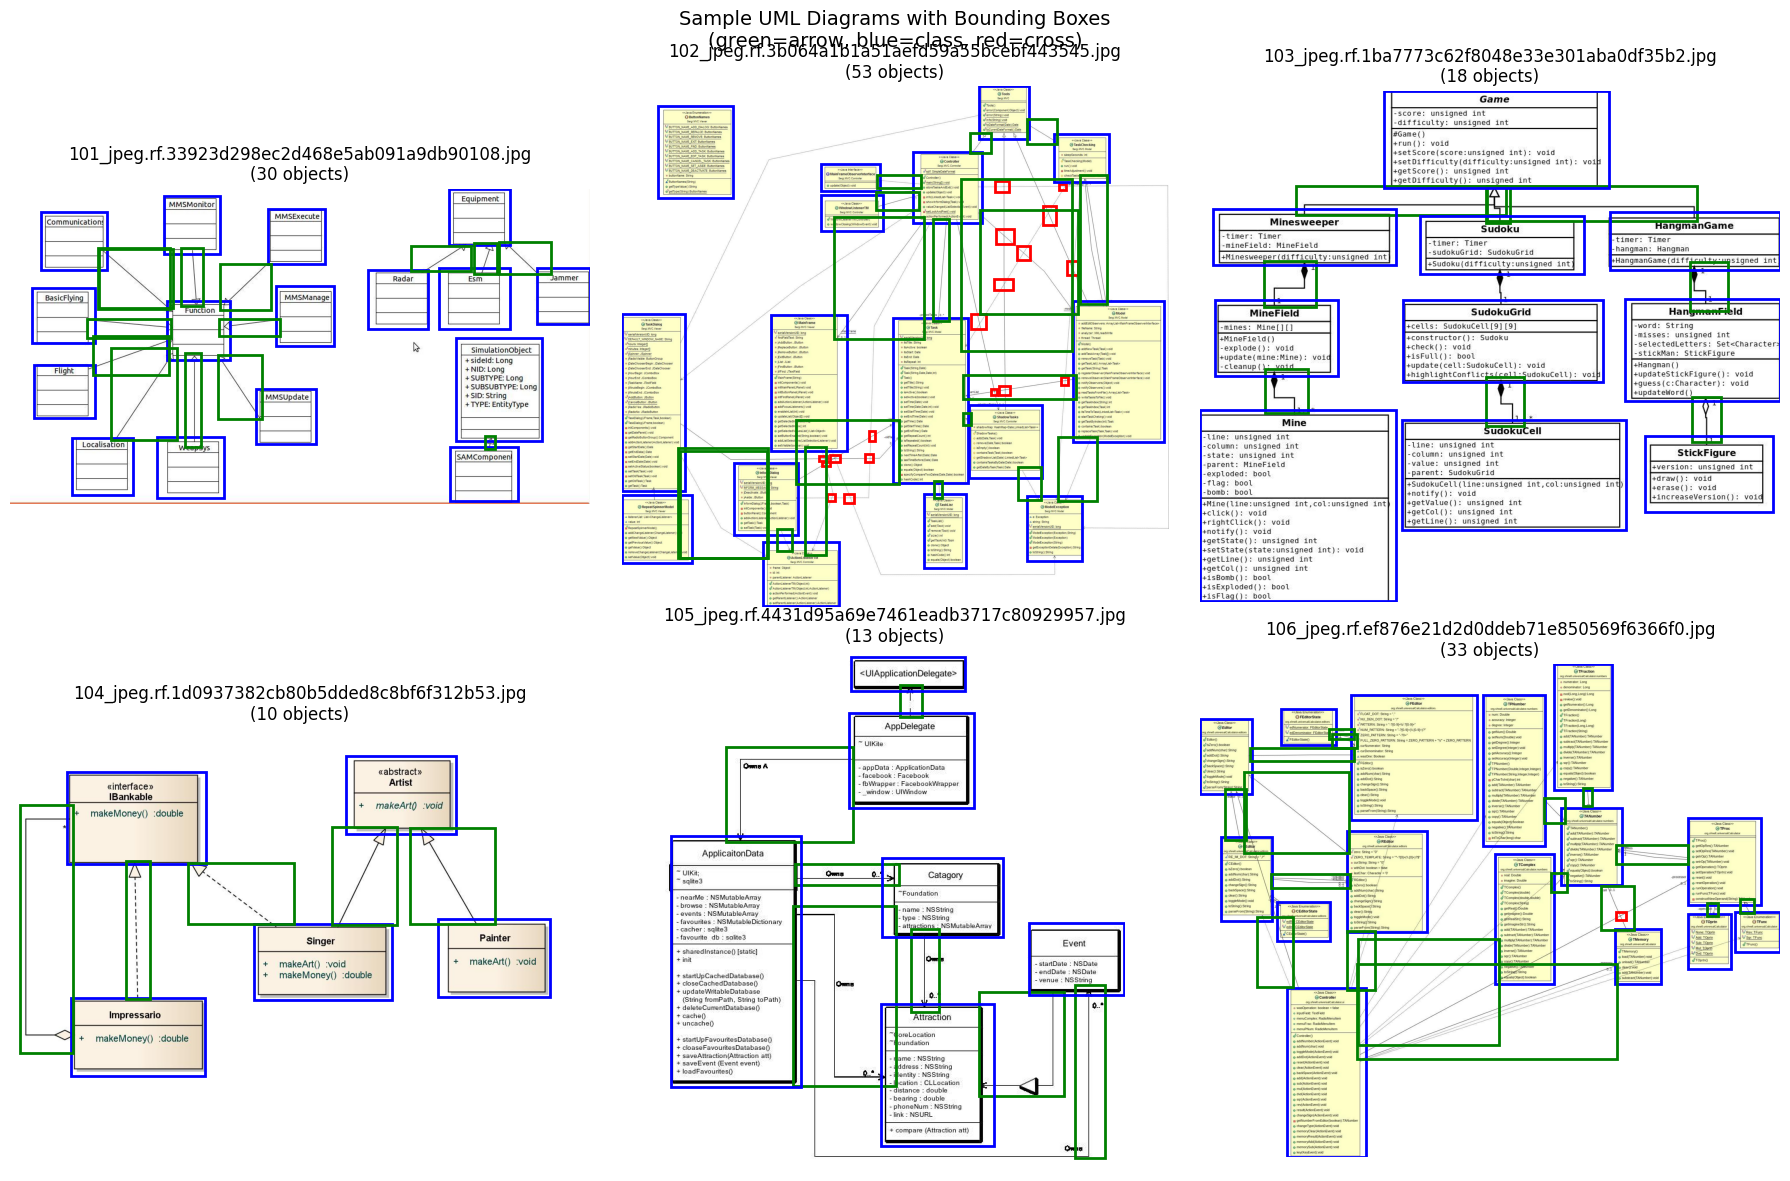

In [11]:
# Display a grid of sample images with annotations
n_samples = min(6, len(train_data))
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, sample in enumerate(train_data[:n_samples]):
    img = Image.open(sample['image'])
    annotations = parse_yolo_annotation(sample['label'], img.size[0], img.size[1])
    
    axes[idx].imshow(np.array(img))
    
    for ann in annotations:
        x1, y1 = ann['x1'], ann['y1']
        width = ann['width']
        height = ann['height']
        color = CLASS_COLORS.get(ann.get('class_id', 0), 'yellow')
        
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        axes[idx].add_patch(rect)
    
    axes[idx].set_title(f"{sample['image'].name}\n({len(annotations)} objects)")
    axes[idx].axis('off')

plt.suptitle("Sample UML Diagrams with Bounding Boxes\n(green=arrow, blue=class, red=cross)", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Load and Explore Quality Ratings

In [12]:
# Load ratings CSV
ratings_path = dataset_dir / "rating_images.csv"

if ratings_path.exists():
    df_ratings = pd.read_csv(ratings_path)
    print(f"Ratings file loaded: {len(df_ratings)} entries")
    print(f"\nColumns: {list(df_ratings.columns)}")
    print(f"\nFirst 10 rows:")
    print(df_ratings.head(10))
else:
    print(f"Ratings file not found at {ratings_path}")

Ratings file loaded: 554 entries

Columns: ['Unnamed: 0', 'name', 'quality']

First 10 rows:
   Unnamed: 0     name  quality
0           0  138.png        4
1           1  167.png        3
2           2  127.png        3
3           3  146.png        3
4           4  142.png        4
5           5  181.png        5
6           6  134.png        2
7           7  137.png        2
8           8  171.png        1
9           9  164.png        3


Quality Rating Distribution:
quality
1     44
2    107
3    208
4    117
5     78
Name: count, dtype: int64


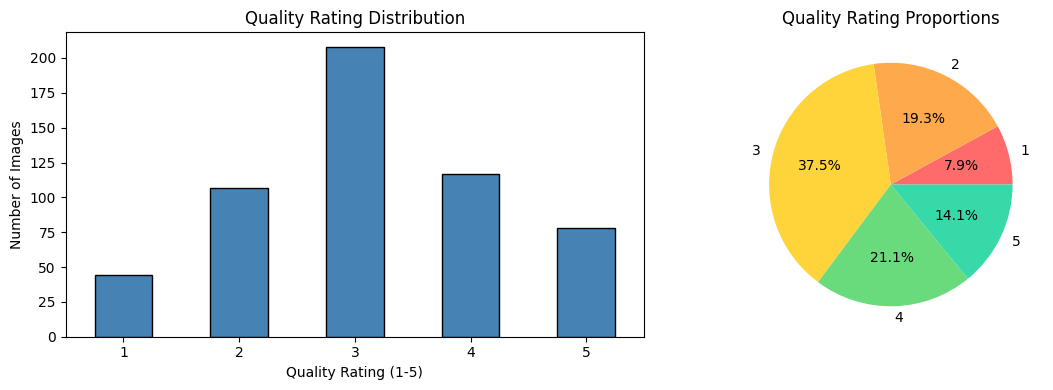


Summary statistics:
count    554.000000
mean       3.140794
std        1.125906
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: quality, dtype: float64


In [13]:
# Analyze quality distribution
if 'df_ratings' in dir():
    print("Quality Rating Distribution:")
    print(df_ratings['quality'].value_counts().sort_index())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Bar chart
    df_ratings['quality'].value_counts().sort_index().plot(
        kind='bar', ax=axes[0], color='steelblue', edgecolor='black'
    )
    axes[0].set_title('Quality Rating Distribution')
    axes[0].set_xlabel('Quality Rating (1-5)')
    axes[0].set_ylabel('Number of Images')
    axes[0].tick_params(axis='x', rotation=0)
    
    # Pie chart
    df_ratings['quality'].value_counts().sort_index().plot(
        kind='pie', ax=axes[1], autopct='%1.1f%%',
        colors=['#ff6b6b', '#ffa94d', '#ffd43b', '#69db7c', '#38d9a9']
    )
    axes[1].set_title('Quality Rating Proportions')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary statistics:")
    print(df_ratings['quality'].describe())

## 9. Annotation Statistics

In [14]:
# Collect statistics across all YOLO annotations
all_annotations = []
all_data = train_data + valid_data + test_data

print(f"Processing {len(all_data)} images...")

for sample in all_data:
    img = Image.open(sample['image'])
    anns = parse_yolo_annotation(sample['label'], img.size[0], img.size[1])
    for ann in anns:
        ann['image'] = sample['image'].name
    all_annotations.extend(anns)

df_annotations = pd.DataFrame(all_annotations)

print(f"\nTotal annotations: {len(df_annotations)}")
print(f"\nClass distribution:")
print(df_annotations['class_name'].value_counts())

Processing 621 images...

Total annotations: 16870

Class distribution:
class_name
arrow    7728
class    7453
cross    1689
Name: count, dtype: int64


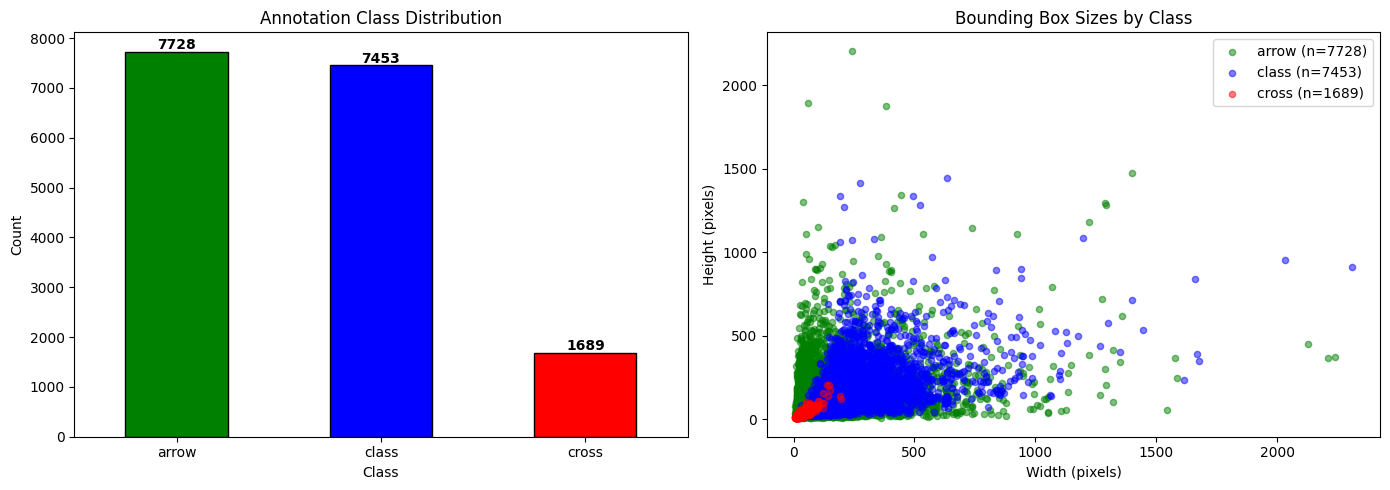

In [15]:
# Plot annotation statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
class_counts = df_annotations['class_name'].value_counts()
colors = [CLASS_COLORS.get(list(CLASS_NAMES.keys())[list(CLASS_NAMES.values()).index(name)], 'gray') 
          for name in class_counts.index]
class_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Annotation Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Add count labels on bars
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Bounding box size distribution
for class_id, class_name in CLASS_NAMES.items():
    mask = df_annotations['class_id'] == class_id
    if mask.any():
        axes[1].scatter(
            df_annotations.loc[mask, 'width'], 
            df_annotations.loc[mask, 'height'],
            c=CLASS_COLORS[class_id],
            alpha=0.5,
            label=f"{class_name} (n={mask.sum()})",
            s=20
        )
axes[1].set_title('Bounding Box Sizes by Class')
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Height (pixels)')
axes[1].legend()

plt.tight_layout()
plt.show()

Objects per image statistics:
count    621.000000
mean      27.165862
std       20.843809
min        8.000000
25%       13.000000
50%       21.000000
75%       32.000000
max      229.000000
dtype: float64


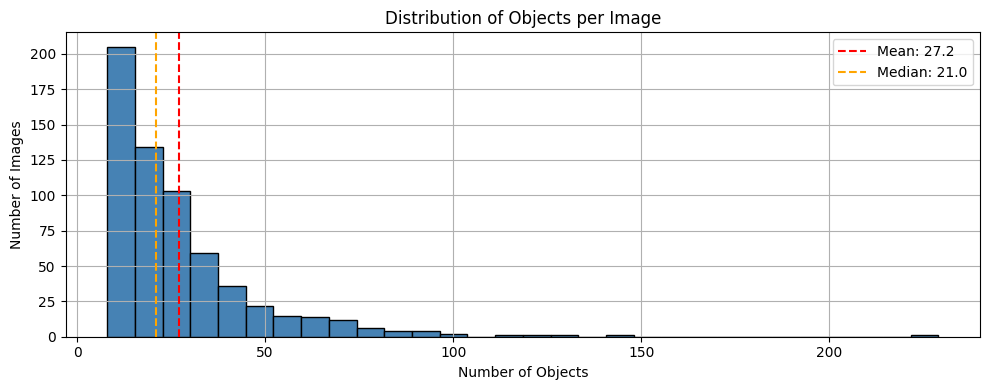

In [16]:
# Objects per image statistics
objects_per_image = df_annotations.groupby('image').size()

print("Objects per image statistics:")
print(objects_per_image.describe())

fig, ax = plt.subplots(figsize=(10, 4))
objects_per_image.hist(bins=30, ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Distribution of Objects per Image')
ax.set_xlabel('Number of Objects')
ax.set_ylabel('Number of Images')
ax.axvline(objects_per_image.mean(), color='red', linestyle='--', label=f'Mean: {objects_per_image.mean():.1f}')
ax.axvline(objects_per_image.median(), color='orange', linestyle='--', label=f'Median: {objects_per_image.median():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

## 10. Faster R-CNN Format (Alternative)

The dataset also includes annotations in Faster R-CNN (PASCAL VOC XML) format.

In [17]:
import xml.etree.ElementTree as ET

def parse_xml_annotation(xml_path):
    """
    Parse Faster R-CNN XML format annotation file (PASCAL VOC format).
    """
    annotations = []
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        
        x1 = float(bbox.find('xmin').text)
        y1 = float(bbox.find('ymin').text)
        x2 = float(bbox.find('xmax').text)
        y2 = float(bbox.find('ymax').text)
        
        annotations.append({
            'class_name': name,
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'width': x2 - x1,
            'height': y2 - y1
        })
    
    return annotations

# Check Faster R-CNN directory
frcnn_dir = dataset_dir / "Faster_R-CNN" / "Faster_R-CNN"
if frcnn_dir.exists():
    xml_files = list(frcnn_dir.glob("*.xml"))
    jpeg_files = list(frcnn_dir.glob("*.jpeg"))
    print(f"Faster R-CNN format:")
    print(f"  XML files: {len(xml_files)}")
    print(f"  JPEG files: {len(jpeg_files)}")
    
    # Show sample
    if xml_files:
        sample_xml = xml_files[0]
        sample_img = sample_xml.with_suffix('.jpeg')
        if sample_img.exists():
            anns = parse_xml_annotation(sample_xml)
            print(f"\nSample {sample_xml.name}: {len(anns)} annotations")
            for ann in anns[:3]:
                print(f"  - {ann['class_name']}: ({ann['x1']:.0f}, {ann['y1']:.0f}) to ({ann['x2']:.0f}, {ann['y2']:.0f})")

Faster R-CNN format:
  XML files: 641
  JPEG files: 639

Sample 1.xml: 14 annotations
  - class: (1, 3) to (113, 32)
  - class: (150, 1) to (261, 44)
  - class: (85, 71) to (197, 110)


## 11. Summary

### Dataset Overview
- **YOLO Format**: `UML_YOLOv8/` with train/valid/test splits
- **Faster R-CNN Format**: `Faster_R-CNN/` with XML annotations
- **Quality Ratings**: `rating_images.csv` with ratings 1-5

### Annotation Classes (from data.yaml)
- `0: arrow` (green) - Relationship arrows between classes
- `1: class` (blue) - UML class boxes
- `2: cross` (red) - Cross markers

### Next Steps
1. **Object Detection (Notebook 02)**: Train/fine-tune YOLOv8 on this dataset
2. **OCR Extraction (Notebook 03)**: Extract text from detected class boxes
3. **Knowledge Graph (Notebook 04)**: Build graph from extracted relationships
4. **GraphRAG Query (Notebook 05)**: Enable natural language queries